# Training Continuous BFN on MNIST

## Imports

In [1]:
import jax.numpy as jnp
import jax
import jax.random as jr
import jax.tree_util as tu
import optax
import einops

from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import bfn.continuous.example_data as example_data
import bfn.continuous.models_mnist as models_mnist
import bfn.continuous.training as training
import bfn.continuous.loss_and_sample as las

## Main

### Defining Dataset and Model

In [3]:
batch_size = 512
mnist_dataset = example_data.MNISTDataset()

dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, collate_fn=jnp.stack)

In [4]:
example_x = mnist_dataset[0]
size = int(jnp.sqrt(example_x.shape[0]))

In [5]:
model = models_mnist.ContinuousOutputDistributionMixer(D=example_x.shape[0], size=size, num_blocks=4, patch_size=4, hidden_size=64, mix_patch_size=512, mix_hidden_size=512)
mu_prior = jnp.zeros_like(example_x)

variables = model.init(jr.PRNGKey(0), example_x, jnp.array(0.5), jnp.array(0.2))
params = variables["params"]

num_params = sum(x.size for x in tu.tree_leaves(params))
print(f"Number of parameters: {num_params}")

Number of parameters: 471535


### Training

In [6]:
LEARNING_RATE = 1e-3
optim = optax.adamw(LEARNING_RATE)
opt_state = optim.init(params)

In [7]:
NUM_EPOCHS = 10

losses = []
key = jr.PRNGKey(0)
sigma_1 = 0.01
for _ in (pbar := tqdm(range(NUM_EPOCHS))):
    epoch_loss = 0.0
    for x_batch in dataloader:
        key, subkey = jr.split(key)
        loss, params, opt_state = training.make_step(model, x_batch, optim, opt_state, params, sigma_1, key=subkey)
        epoch_loss += loss
    losses.append(epoch_loss)
    pbar.set_description(f"Loss: {epoch_loss:.1f}")

losses = jnp.array(losses)

Loss: 23728.5: 100%|██████████| 10/10 [01:14<00:00,  7.44s/it]


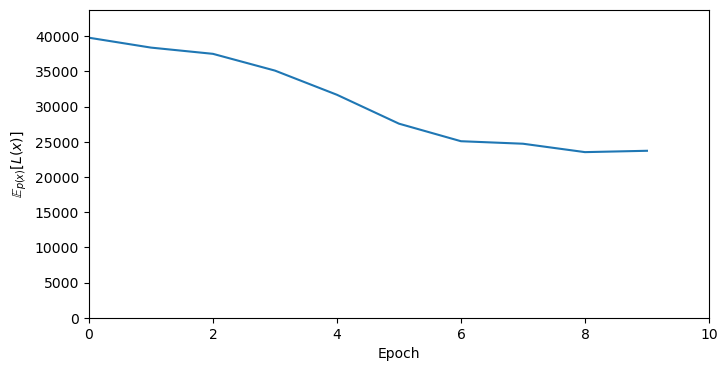

In [8]:
# Plot losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(losses)

_ = ax.set_xlabel("Epoch")
_ = ax.set_ylabel(r"$\mathbb{E}_{p(x)}[L(x)]$")  # Not actually the expectation because summing loss in each epoch
_ = ax.set_xlim(0, losses.shape[0])
_ = ax.set_ylim(0, 1.1 * jnp.max(losses))

### Sampling from Trained Model

In [9]:
x_hat = las.sample(params, model, jnp.array(sigma_1), 600, key=jr.PRNGKey(12))

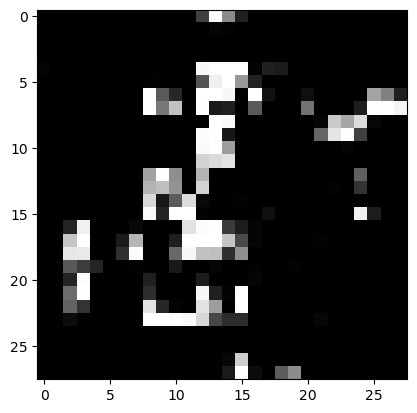

In [10]:
# Samples currently no good, probably because network isn't expressive enough
x_hat_rearranged = einops.rearrange(x_hat, "(h w) -> h w", h=size, w=size)
plt.imshow(x_hat_rearranged, cmap="gray")